# 2/7/20
# 2/10/20

Новая задача: пересчитать сечения с новыми эффективностями

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
%matplotlib inline

In [2]:
class Analyzer():
    def __init__(self, MC=False):
        self.files = None
        self.frame = None
        self.result_frame = None
        self.MC = MC
        self.result_dict = {}
        
    def get_triggers(self, x, extended=False):
        def error(k, n):
            return np.sqrt( (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2 )
        
        y = (x-1).value_counts()
        T = y[0] if 0 in y else 0
        C = y[1] if 1 in y else 0
        TC = y[2] if 2 in y else 0

        effT = (TC+1)/(TC+C+2)
        effC = (TC+1)/(TC+T+2)
        eff = 1 - (1-effT)*(1-effC)
        
        errT = error(TC, C+TC)
        errC = error(TC, T+TC)
        err = np.sqrt( np.square((1-effT)*errC) + np.square((1-effC)*errT) )

        return [effT, errT, effC, errC, eff, err] if extended else [eff, err]
        
    def open_files(self, folder):
        self.files = glob.glob(folder+'/*[0-9].csv')
        frames = [ pd.read_csv(file).assign(index=i) for i, file in zip(range(100), self.files) ]
        self.frame = pd.concat(frames, sort=False, ignore_index=True)
        len0 = self.frame.shape[0]
        self.frame = self.frame.query('trigbits>=1&trigbits<=3')
        print('Bad triggers events dropeed:', len0 - self.frame.shape[0], '| Total num: ', self.frame.shape[0], 
             '| Energy points:', self.frame['index'].nunique() )
        
    def merge_points(self, arr):
        for c in arr:
            self.frame['merged_name'] = self.frame.ebeam.replace(c[0], c[1])
    
    def add_luminosities(self, lumfile):
        lum = pd.read_csv(lumfile).rename({'label':'ebeam'}, axis=1).\
                    sort_values(by='ebeam').drop_duplicates(subset=['ebeam']).drop( ['err'], axis=1)
        
        if( lum.shape[0]!=self.frame.ebeam.unique().shape[0] ):
            warnings.warn('Number of records in data differs from num of records in lum file')
        
        self.frame = self.frame.merge(lum, on='ebeam')
        
    def get_mean_energy_table(self):
        if not('merged_name' in self.frame):
            self.frame['merged_name'] = self.frame.ebeam
        table = self.frame.drop_duplicates(subset=['ebeam', 'lum'])
        table = table.assign(elum = table['emeas']*table['lum'] )
        table = table.groupby('merged_name').agg({'elum': 'sum', 'lum':'sum', 'emeas' : ['min', 'max']})
        table['emean'] = table[('elum','sum')]/table[('lum', 'sum')]
        table['dEmin'] = table[('emean','')] - table[('emeas', 'min')]
        table['dEmax'] = table[('emeas', 'max')] - table[('emean','')]
        table.drop([('emeas', 'min'),('emeas', 'max'),('elum', 'sum')], axis=1, inplace=True)
        table.columns = ['lum_sum', 'emean', 'demin', 'demax']
        return table
        
    def reshaping(self):
        self.result_frame = \
            self.frame.groupby('merged_name').agg({'ksminv': lambda x: list(x), 'trigbits': self.get_triggers})
        return
        
    def baseline11(self):
        self.open_files('outputs/2011')
        self.add_luminosities('/spoolA/petrov/research/inputs/11/lum.dat')
        arr11 = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)] 
        self.merge_points(arr11)
        self.reshaping()
        energies = self.get_mean_energy_table()
        self.result_frame = self.result_frame.join(energies)
        
        
        

In [3]:
a = Analyzer()
a.baseline11()

Bad triggers events dropeed: 19 | Total num:  8400 | Energy points: 40


In [4]:
len(a.frame)

8400

In [5]:
f = a.result_frame

In [6]:
f.head()

,ksminv,trigbits,lum_sum,emean,demin,demax
merged_name,,,,,,
525.0,"[424.09732, 478.60085999999995, 449.1980599999...","[0.481050128293385, 0.01922738795389701]",469.339,523.580,0.0,0.0
537.5,"[494.11465, 14.376098999999998, 496.9342299999...","[0.9671767264890474, 0.006699160372534455]",554.231,537.410,0.0,0.0
550.0,"[576.6827, 498.27145, 504.13055, 551.39276, 50...","[0.6784072471606273, 0.03119468492796836]",493.501,548.440,0.0,0.0
562.5,"[501.2009, 510.38516, 499.17462, 520.2958, 500...","[0.9521291448516579, 0.012846519655340878]",549.094,562.134,0.0,0.0
575.0,"[469.62625, 497.8826, 535.2342, 519.1692, 488....","[0.6678714467129042, 0.04482254438689559]",493.710,575.310,0.0,0.0


In [7]:
import iminuit
import probfit as pf
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})
mass_bound = (450, 550)

In [8]:
#2 гаусса
def constant(x):
    return 1
def gauss(x, mu, sigma):
    return pf.gaussian(x, mu, sigma)

norm_sig = pf.rename( pf.Normalized( gauss, mass_bound ), ['x', 'M', '$\\sigma$'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

MLim = (498.1, 5.0)
sigmaLim = (6.04, 5.0)

limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\\sigma$": [sigmaLim[0] - sigmaLim[1], sigmaLim[0] + sigmaLim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000]
}
errors = {
    "error_M": 1,
    "error_$\\sigma$": 0.1,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
}

pf.describe(pdf)

['x', 'M', '$\\sigma$', '$N_{sig}$', '$N_{bkg}$']

In [14]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=False):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma$": 4.26, "$N_{sig}$": np.size(dic), "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])
        ax_main.grid(ls=':')
        box_1 = {'facecolor':'black', 'boxstyle': 'round'}

        if binnedLik:
            likelihood.draw(minuit=mt, print_par=True);
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound, print_par=True)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events per bin', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        ax_bottom.grid(ls=':')
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
#         plt.savefig(f'../outputs/{year}/figures/fit_e{energy}.pdf')
    return mt, likelihood

In [37]:
it = f.iterrows()
fit_frame = pd.DataFrame(columns=[ 'Mass', 'Sigma', 'Nsig', 'Nbkg', 
                                  'Merr', 'Serr', 'Nerr', 'Nbkg'])

In [62]:
i = next(it)
print('Energy:', i[0])

Energy: 637.5


Migrad quality: True
Real: 473 Found: 473.03376459328706


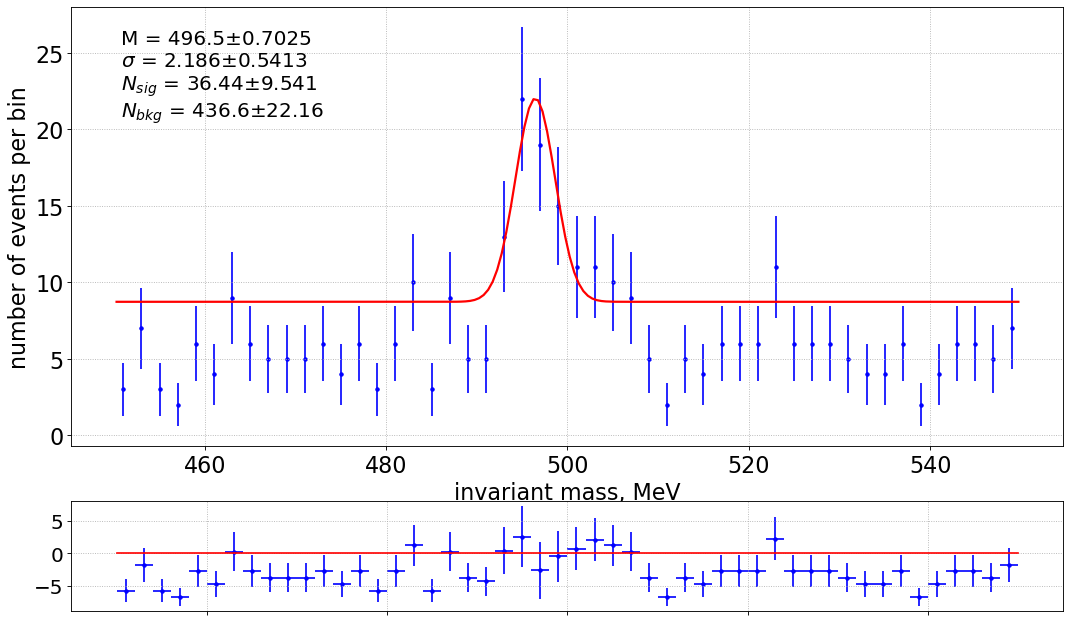

In [63]:
mt, lk = fitter( np.array( i[1]['ksminv'] ), 50, i, binnedLik=False)
fit_frame.loc[ i[0] ] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size( i[1]['ksminv'] ), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [47]:
fit_frame

,Mass,Sigma,Nsig,Nbkg,Merr,Serr,Nerr,Nbkg
525.0,496.124846,5.359877,772.684378,197.278110,0.213588,0.177328,29.539438,17.237246
537.5,497.989743,4.671209,872.755169,194.369187,0.174883,0.153364,31.191566,17.159424
550.0,496.924988,5.309434,356.683461,309.350731,0.352238,0.323103,22.392748,21.306673
562.5,497.622840,4.660836,368.014312,241.983989,0.291909,0.268369,21.688346,18.554134


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

%matplotlib inline

Получить данные по 11 году

In [100]:
data = [
    pd.read_csv('/spoolA/petrov/research/outputs/11/tables/signal_table11.csv', index_col=['name']),
    pd.read_csv('/spoolA/petrov/research/outputs/12/tables/signal_table12.csv', index_col=['name']),
    pd.read_csv('/spoolA/petrov/research/outputs/17/tables/signal_table17.csv', index_col=['name']),
]

Триггеры

In [101]:
tr = [
    pd.read_csv('/spoolA/petrov/research/outputs/11/tables/triggers11.csv', index_col=['name']),
    pd.read_csv('/spoolA/petrov/research/outputs/12/tables/triggers12.csv', index_col=['name']),
    pd.read_csv('/spoolA/petrov/research/outputs/17/tables/triggers17.csv', index_col=['name']),
]

In [102]:
data = [ d.join( t[['TrigEff', 'TrigErr']] ) for d, t in zip(data,tr) ]

Получить моделирование

In [103]:
reg_eff_new = pd.read_csv('outputs/model_new/summary.csv').rename({'Unnamed: 0':'Energy'},axis=1).sort_values('Energy')
reg_eff_old = pd.read_csv('outputs/model_old/summary.csv').rename({'Unnamed: 0':'Energy'},axis=1).sort_values('Energy')

In [104]:
for r in [reg_eff_new, reg_eff_old]:
    r['soft'] = r.Nsig/r.Soft_tot
    r['soft_err'] = np.sqrt(r.Nsig)/r.Soft_tot
    r['all'] = r.Nsig/r.All_tot
    r['all_err'] = np.sqrt(r.Nsig)/r.All_tot

In [105]:
reg_eff_new.head()

,Energy,Nsig,Soft_tot,All_tot,soft,soft_err,all,all_err
28,525.0,2728,10038.0,20000.0,0.271767,0.005203,0.13640,0.002612
10,537.5,2490,8783.0,20000.0,0.283502,0.005681,0.12450,0.002495
32,550.0,2235,7905.0,20000.0,0.282732,0.005980,0.11175,0.002364
13,562.5,2059,7350.0,20000.0,0.280136,0.006174,0.10295,0.002269
8,575.0,1917,6821.0,20000.0,0.281044,0.006419,0.09585,0.002189


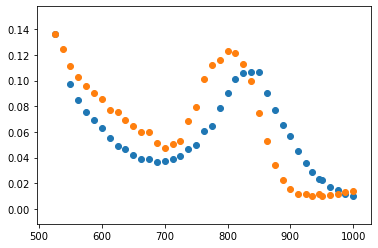

In [106]:
plt.scatter(reg_eff_old.Energy, reg_eff_old['all'])
plt.scatter(reg_eff_new.Energy, reg_eff_new['all'])

Видимое сечение

In [107]:
data[0].head()

,lum,dEmin,dEmax,Emean,Nsig,dNsig,TrigEff,TrigErr
name,,,,,,,,
525.0,469.34,0.0,0.0,523.58,794.66,29.02,0.5197,0.0202
537.5,554.23,0.0,0.0,537.41,885.51,30.27,0.9714,0.0061
550.0,493.50,0.0,0.0,548.44,380.02,20.00,0.7381,0.0276
562.5,549.09,0.0,0.0,562.13,386.98,20.26,0.9679,0.0099
575.0,493.71,0.0,0.0,575.31,158.02,12.99,0.7425,0.0408


In [108]:
def reg_eff(data, soft=True, new=True):
    data = data.copy()
    reg_df = reg_eff_new if new else reg_eff_old
    field = 'soft' if soft else 'all'
    
    data['RegEff'] = np.interp(data.index, reg_df.Energy, reg_df[field] )
    data['RegErr'] = np.interp(data.index, reg_df.Energy, reg_df[field+'_err'] )
    
    return data

In [121]:
data_new = [ reg_eff(d, soft=True, new=True) for d in data ]
data_old = [ reg_eff(d, soft=True, new=False) for d in data ]

In [122]:
data_old[0].head()

,lum,dEmin,dEmax,Emean,Nsig,dNsig,TrigEff,TrigErr,RegEff,RegErr
name,,,,,,,,,,
525.0,469.34,0.0,0.0,523.58,794.66,29.02,0.5197,0.0202,0.271767,0.005203
537.5,554.23,0.0,0.0,537.41,885.51,30.27,0.9714,0.0061,0.270140,0.005650
550.0,493.50,0.0,0.0,548.44,380.02,20.00,0.7381,0.0276,0.268512,0.006096
562.5,549.09,0.0,0.0,562.13,386.98,20.26,0.9679,0.0099,0.267316,0.006480
575.0,493.71,0.0,0.0,575.31,158.02,12.99,0.7425,0.0408,0.269742,0.006958


In [123]:
data_new[0].head()

,lum,dEmin,dEmax,Emean,Nsig,dNsig,TrigEff,TrigErr,RegEff,RegErr
name,,,,,,,,,,
525.0,469.34,0.0,0.0,523.58,794.66,29.02,0.5197,0.0202,0.271767,0.005203
537.5,554.23,0.0,0.0,537.41,885.51,30.27,0.9714,0.0061,0.283502,0.005681
550.0,493.50,0.0,0.0,548.44,380.02,20.00,0.7381,0.0276,0.282732,0.005980
562.5,549.09,0.0,0.0,562.13,386.98,20.26,0.9679,0.0099,0.280136,0.006174
575.0,493.71,0.0,0.0,575.31,158.02,12.99,0.7425,0.0408,0.281044,0.006419


In [124]:
def cross_sec(data):
    d = data.copy()
    d['CS'] = d.Nsig/(d.lum*d.TrigEff*d.RegEff)
    d['dCS'] = d['CS']*np.sqrt( (d.dNsig/d.Nsig)**2 + (d.TrigErr/d.TrigEff)**2 +
                                      (d.RegErr/d.RegEff)**2 )
    return d

In [125]:
cs11o = [ cross_sec(d) for d in data_old ]
cs11n = [ cross_sec(d) for d in data_new ]

In [126]:
cs11o[0];

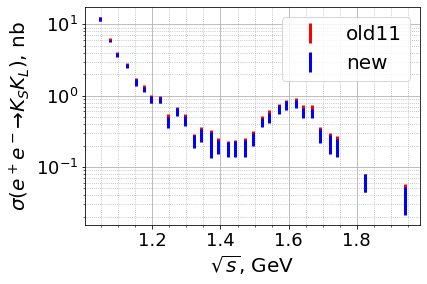

In [127]:
plt.errorbar(cs11o[0].Emean*2e-3, cs11o[0].CS, yerr=cs11o[0].dCS, fmt='ro', elinewidth=3, ms=0, label='old11')
plt.errorbar(cs11n[0].Emean*2e-3, cs11n[0].CS, yerr=cs11n[0].dCS, fmt='bo', elinewidth=3, ms=0, label='new')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma(e^+e^- \\to K_SK_L)$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18);
ax.legend(fontsize=20, frameon=True);

plt.grid(linestyle = '-');
ax = plt.gca();
ax.minorticks_on();
ax.grid(which='minor', linestyle = ':');

# plt.savefig('cs.pdf')

In [130]:
cs11n[2].to_csv('17_alls.csv')